In [1]:
import numpy as np
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = "retina"
from matplotlib import rcParams
rcParams['savefig.dpi'] = 550
rcParams['font.size'] = 20
plt.rc('font', family='serif')
from scipy import interpolate
import astropy.stats as astro_stats
from scipy.optimize import curve_fit
from astropy.io import ascii
from scipy.signal import find_peaks
import scipy.integrate as integrate
from scipy.signal import savgol_filter

### Light Curve Cases

(18.884874539911007, 17.86530862476614)

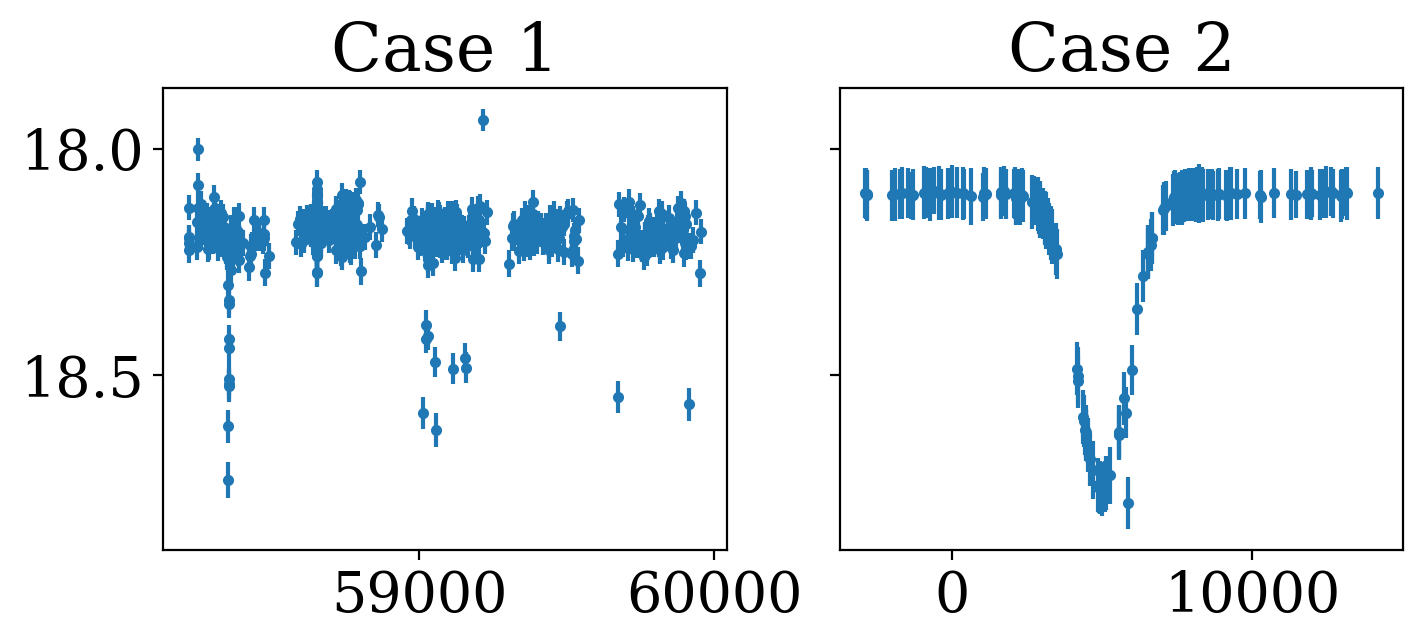

In [356]:

# light curve candidate (1)
lc2 = ascii.read("https://ztf.snad.space/dr17/csv/802211300046586")
x, y, yerr = lc2['mjd'], lc2['mag'], lc2['magerr']

# light curve candidate (2)
N = 150 # number of detections
time = np.random.randint(100, 10_000, N) + np.random.normal(10, 3_000, N)
ts = np.argsort(time)
time = time[ts]

line = lambda x, a, b: x*a + b
dip = lambda x, a, b, c: a*np.exp(-((x-b)**2)/(2*c**2))

mr = np.zeros(N) + 18.1 + np.random.normal(0, 0.003, N) + dip(time, 0.65, 5_000, 850) + dip(time, 0.45, 5_900, 50)
mr_err = line(mr, 0.003, 1e-3) + np.random.normal(0.001, 0.003, len(mr))

x2, y2, yerr2 = time, mr, mr_err

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(8, 3), sharey=True)

ax[0].errorbar(x, y, yerr, fmt='.')
ax[0].set_title("Case 1")

ax[1].errorbar(x2, y2, yerr2, fmt='.')
ax[1].set_title("Case 2")

ax[1].set_ylim(ax[1].set_ylim()[::-1])

## Function Families 

1. Absolute deviation from biweight mean and scale
2. Dip edge detector

In [407]:
def deviation(mag, mag_err):
    """Calculate the running deviation of a light curve for outburst or dip detection.
    
    d >> 0 will be dimming
    d << 0 (or negative) will be brightenning
    
    
    Parameters:
    -----------
    mag (array-like): Magnitude values of the light curve.
    mag_err (array-like): Magnitude errors of the light curve.

    Returns:
    --------
    dev (array-like): Deviation values of the light curve.
    """
    # Calculate biweight estimators
    R, S = astro_stats.biweight_location(mag), astro_stats.biweight_scale(mag)

    return (mag - R) / np.sqrt(mag_err**2 + S**2)   


def calc_dip_edges(xx, yy, _cent, atol=0.2):
    """Crude estimation of the edges of a dipper given the centroid. 
    
      Parameters
      ----------
      xx (array-like): time axis
      yy (array-like): dev
      _cent (float): centroid time 
      atol (float): tolerance to the median. Default is 0.2
    """
    
    indices_forward = np.where((xx > _cent) & np.isclose(yy, np.median(yy) - 0.011*np.median(yy), atol=atol))[0]
    t_forward = xx[indices_forward[0]] if indices_forward.size > 0 else 0
    
    indices_back = np.where((xx < _cent) & np.isclose(yy, np.median(yy) - 0.011*np.median(yy), atol=atol))[0]
    if indices_back.size > 0:
        t_back = xx[indices_back[-1]]
    else:
        t_back = 0
        
    # Diagnostics numbers
    
    # How many detections above the median thresh in the given window?
    _window_ = (xx>t_back) & (xx<t_forward)
    sel_1_sig = (yy[_window_]>np.median(yy) + 1*np.std(yy)) # detections above 1 sigma
    N_thresh_1 = len((yy[_window_])[sel_1_sig])
    
    return t_forward, t_back, (t_forward-_cent), N_thresh_1

## Test `window location width`

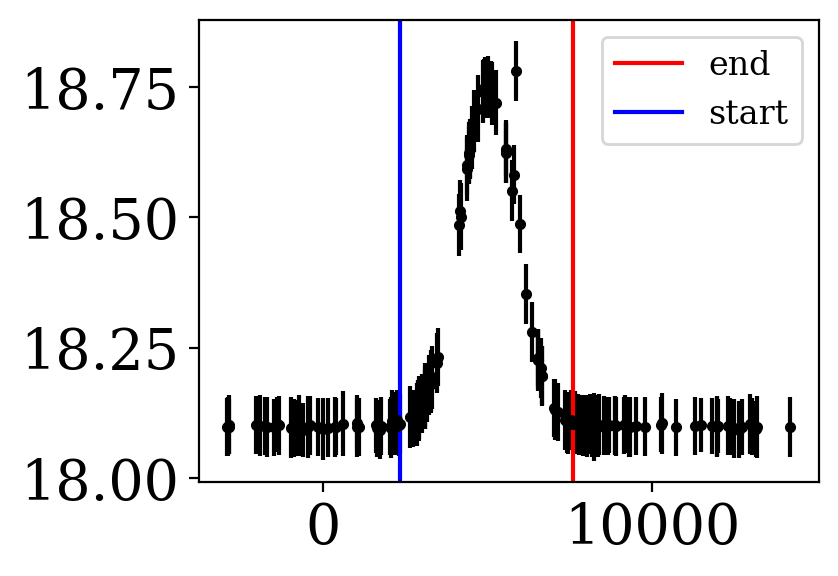

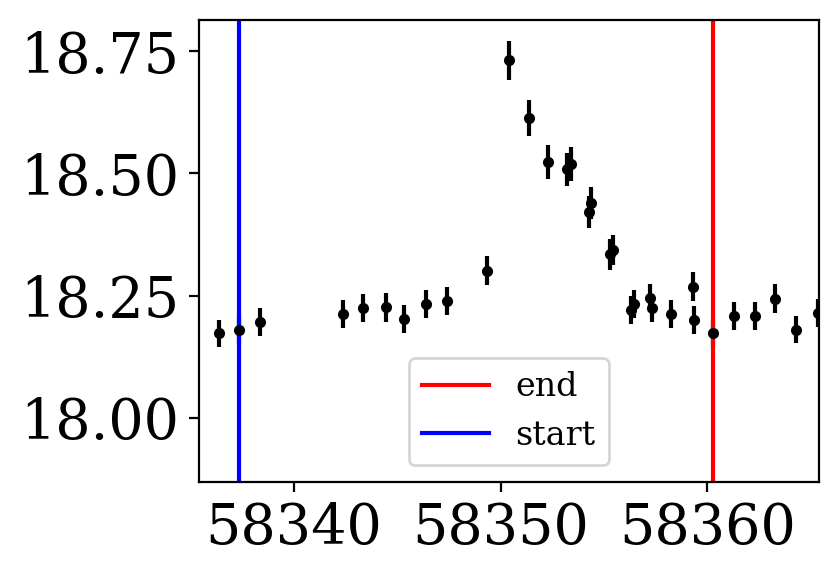

In [408]:
# test on lc (2)
plt.figure(figsize=(4, 3))
teg = calc_dip_edges(x2, y2, 6_000)

plt.errorbar(x2, y2, yerr2, fmt='.', color='k')
plt.axvline(teg[0], color='red', label='end')
plt.axvline(teg[1], color='blue', label='start')
plt.legend(fontsize=12)

plt.figure(figsize=(4, 3))
teg = calc_dip_edges(x, y, 58350.3775)

plt.errorbar(x, y, yerr, fmt='.', color='k')
plt.axvline(teg[0], color='red', label='end')
plt.axvline(teg[1], color='blue', label='start')
plt.xlim(58350.3775-15, 58350.3775+15)
plt.legend(fontsize=12)

In [474]:
def gp_my_dip(x, y, yerr):
    kernel = kernels.RationalQuadraticKernel(log_alpha=0.5, metric=100)
    #kernel += kernels.ExpSine2Kernel(1, log_period=0.5)
    gp = george.GP(kernel)
    gp.compute(x, yerr)

    x_pred = np.linspace(min(x), max(x), 5_500)
    pred, pred_var = gp.predict(y, x_pred, return_var=True)
    
    init_log_L = gp.log_likelihood(y)
    
    from scipy.optimize import minimize

    def neg_ln_like(p):
        gp.set_parameter_vector(p)
        return -gp.log_likelihood(y)

    def grad_neg_ln_like(p):
        gp.set_parameter_vector(p)
        return -gp.grad_log_likelihood(y)

    result = minimize(neg_ln_like, gp.get_parameter_vector(), jac=grad_neg_ln_like)

    gp.set_parameter_vector(result.x)
    
    final_log_L = gp.log_likelihood(y)
    pred, pred_var = gp.predict(y, x_pred, return_var=True)
    
    return x_pred, pred, pred_var, {"init_log_L": init_log_L, 
                                   "final_log_L": final_log_L, 
                                   "success_status":result['success']}

In [509]:
def calculate_integral(x0, y0, yerr0):
    """ Sigma (Mn - R) (Dn+1 - Dn-1)/2"""
    R = astro_stats.biweight_location(y0)
    S = astro_stats.biweight_scale(y0)
    
    integral = sum((y0[1::] - R) * (np.diff(x0)/2))
    
    integral_error = sum((yerr0[1::]**2 + S**2) * (np.diff(x0)/2)**2)
    
    return integral, np.sqrt(integral_error)

def integral_score(I_start, s_start, I_end, s_end):
    
    return ((I_start - I_end)/(np.sqrt(s_start**2 + s_end**2)))


def calc_gp_duration(gp_data, x0, y0, yerr0, R, diagnostic=True):
    """
    
    R: biweight location of the original distribution!
    """
    gpx, gpy, gpyerr, _ = gp_data
    
    loc_gp = gpx[np.argmax(gpy)] # centroid of gp fit
    
    M = np.zeros(len(gpy)) + R
    
    # Find the indexes where the two functions intersect
    idx = np.argwhere(np.diff(np.sign(M - gpy))).flatten()
    
    tdx = gpx[idx] # gp times where they intersect
    tdx_phase = loc_gp - tdx # normalize wrt to peak loc
    
    # select phase
    w_pos = tdx_phase>0
    w_neg = tdx_phase<0
    
    # Select the edges of the phase
    
    try:
        w_end = min(tdx[w_neg])
        w_start = max(tdx[w_pos])
    except:
        #assert ("Failed to find start or end")
        return False
    
    # Select the GP area of interest
    sel_gp = np.where((gpx>=w_start) & (gpx<=w_end))
    
    # selected gaussian process curves....
    _gpx, _gpy, _gpyerr = gpx[sel_gp], gpy[sel_gp], gpyerr[sel_gp]
    _gpyerr2 = np.sqrt(_gpyerr)
    
    gp_left = _gpx <= loc_gp # left side indicies
    gp_right = _gpx >= loc_gp # right side indicies
    
    # left gp 
    left_gpx, left_gpy, left_gpyerr2 =  _gpx[gp_left], _gpy[gp_left], _gpyerr[gp_left]
    
    # right gp
    right_gpx, right_gpy, right_gpyerr2 =  _gpx[gp_right], _gpy[gp_right], _gpyerr[gp_right]
    
    
    integral_left = calculate_integral(left_gpx, left_gpy, left_gpyerr2)
    integral_right = calculate_integral(right_gpx, right_gpy, right_gpyerr2)
    
    IScore = integral_score(integral_left[0], integral_left[1], 
                           integral_right[0], integral_right[1])

    summary = {"assymetry_score": IScore, 
              "left_error": integral_left[1],
              "right_error": integral_right[1], 
              "log_sum_error": np.log10(sum(_gpy/_gpyerr2**2))}
    
    if diagnostic:
        # diagnostic fits
        plt.figure(figsize=(3,3))
        plt.axvline(w_start, color='red')
        plt.axvline(w_end, color='green')


        plt.scatter(gpx[idx], gpy[idx])
        plt.plot(gpx, gpy)
        plt.axhline(astro_stats.biweight_location(y0))
        plt.plot(gpx[sel_gp], gpy[sel_gp])
        plt.axvline(loc_gp, color='k', ls='--')
        plt.ylim(plt.ylim()[::-1])
        plt.errorbar(x0, y0, yerr0, color='k', fmt='.')
        plt.axhline(np.mean(y0), color='green', lw=2)
        plt.fill_between(_gpx, _gpy-np.sqrt(_gpyerr), _gpy+np.sqrt(_gpyerr), alpha=0.4)
        plt.title(f"{summary}, and logsum-err: {np.log10(sum(_gpy/(_gpyerr)))}")
        
    return summary
    

In [510]:
def summarize_dev_dips(times, dips, power_thresh=3, loc_peak_thresh=6, peak_close_rmv=15):
    
    yht = savgol_filter(dips, 11, 8) # try savgol smoothing...
    
    # Scipy peak finding algorithm
    pks, _ = find_peaks(yht, height=loc_peak_thresh, distance=500)

    pks = np.sort(pks)[::-1] # sort the reverse peaks
    
    # Time of peaks and dev of peaks
    t_pks, p_pks = times[pks], dips[pks]
    
    if len(pks)>1:
        # remove peaks that are too close to each other
        t_pks = np.array([t_pks[i] for i in range(-1, len(t_pks)-1) if ~np.isclose(t_pks[i],
                                                                             t_pks[i+1],
                                                                             atol=peak_close_rmv)]) # 5 day tolerance window...

        p_pks = np.array([p_pks[i] for i in range(-1, len(t_pks)-1) if ~np.isclose(t_pks[i],
                                                                            t_pks[i+1],
                                                                            atol=peak_close_rmv)])
        srt = np.argsort(t_pks) # argsort the t_pks

        t_pks, p_pks = t_pks[srt], p_pks[srt] # rename variables...
    
    N_peaks = len(t_pks) # number of peaks with removed
    
    # summarize peak information
    dip_summary = {}
    
    i = 0
    for time_ppk, ppk in zip(t_pks, p_pks):
        _edges = calc_dip_edges(times, dips, time_ppk, atol=0.2)
        
        dip_summary[f'dip_{i}'] = {
            "peak_loc": time_ppk,
            'window_start': _edges[0],
            'window_end': _edges[1],
            "N_1sig_in_dip": _edges[-1], 
            'loc_forward_dur': _edges[2],
            "dip_power":ppk
        }
        
        i+=1
    
    return N_peaks, dip_summary

In [511]:
from george import kernels
import george

## Light Curve (1)

working on dip_0
working on dip_1


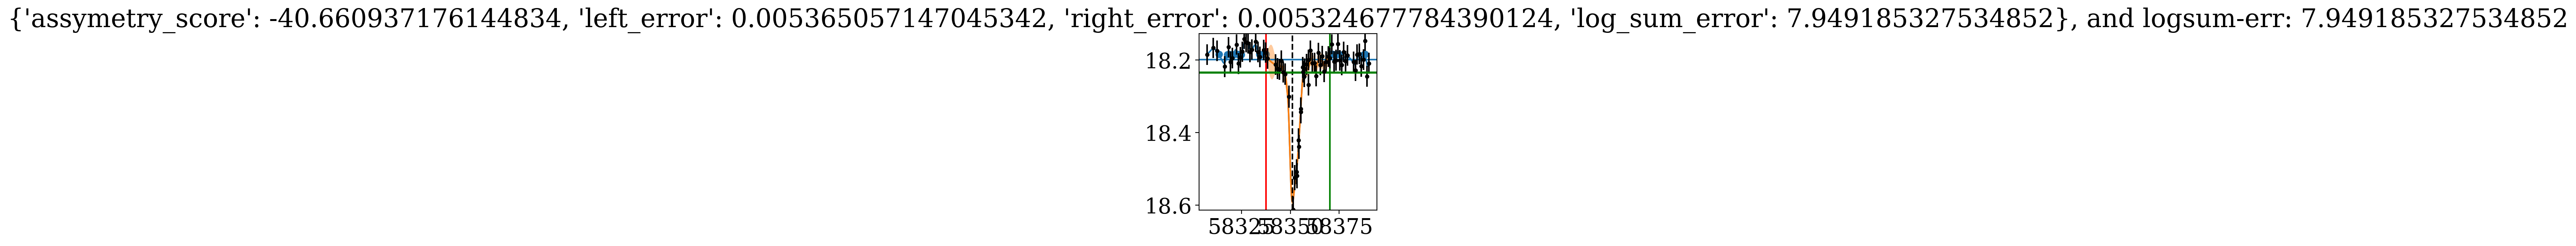

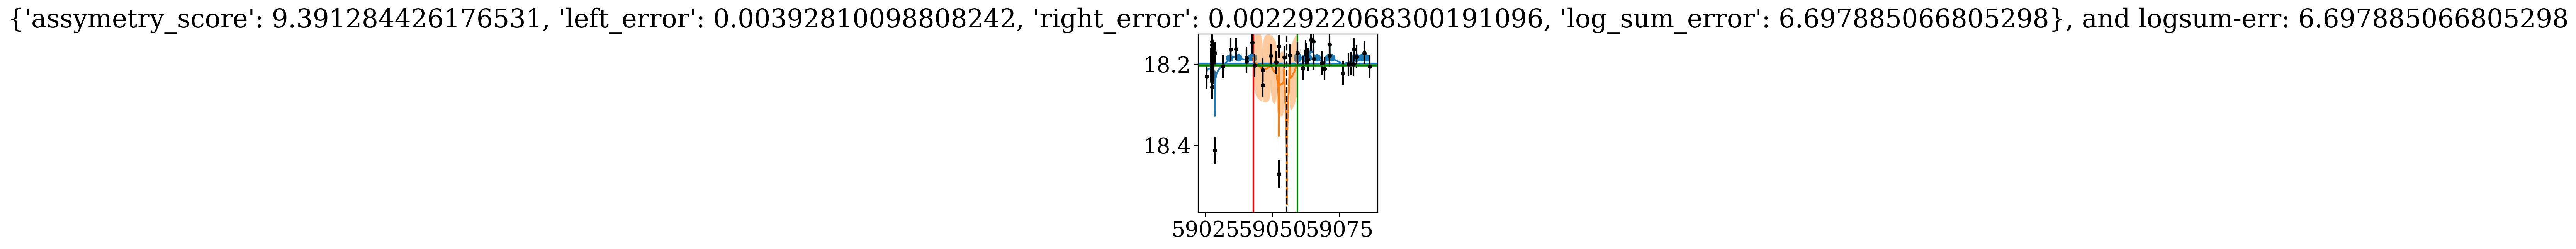

In [519]:
inf = summarize_dev_dips(x, deviation(y, yerr), 
                        peak_close_rmv=25,loc_peak_thresh=6)


for k in inf[1].keys():
    _i = inf[1][f"{k}"]
    if _i['N_1sig_in_dip']>0:


        w_i, w_e = _i['window_end'], _i['window_start']
        
        print (f"working on {k}")
    
        
        x_select = np.where((x>w_i-30) & (x<w_e+30))
        xdat, ydat, yerrdat = x[x_select], y[x_select], yerr[x_select]



        if len(xdat)>0:
            
            gpm = gp_my_dip(xdat, ydat, yerrdat)

            gp_inte = calc_gp_duration(gpm, xdat, ydat, yerrdat, astro_stats.biweight_location(y))
            

In [535]:
# output columns
output_cols = ["biweight_scale",
               "frac_above_2_sigma", 
               "M_stat",
               "Ndips",
               "Rate_dip", # define as the number of significant dips per baseline of the lc
               "best_dip_power", # we will explain what a best dip is considered as...
               "best_dip_frac1sig",
              "integral_score", 
              "gp_logsum_err", 
              "left_integral_error", 
              "right_integral_error"]


def frac_above_dev(dev):
    """Calculate the fraction of detections above 2 sigma from the deviation"""
    M = np.median(dev)
    # fraction above 2-sigma from the M
    two_sig = M + 2*np.std(dev)
    
    if len(dev)>0:
        return len(dev[dev>two_sig])/len(dev)
    else:
        return 0


def assymetry_yso_M(mag):
    """Calculate the magnitude assymetry score defined by Hillenbrand et al. 2022 (https://iopscience.iop.org/article/10.3847/1538-3881/ac62d8/pdf).

    Described in the paper: 
    Objects that have M values <0 are predominately brightening,
    objects with M values >0 are predominantly dimming, and
    objects with M values near 0 have symmetric light curves.

    Parameters:
    -----------
    mag (array-like): Magnitude values of the light curve.
    
    Returns:
    --------
    assymetry (float): Assymetry score.
    """
    
    if len(mag)>0:
        mag_decile = np.percentile(mag, [10, 90])    

        return (np.mean(mag_decile) - np.nanmedian(mag))/np.nanstd(mag)
    else:
        return 0

In [565]:
def calc_my_features(time, mag, mag_err, flag, band, custom_cols=output_cols):
    """Calculate...."""
    
    summary_ = {}
    
    try:
        # Select good detections and only r-band light curves...
        rmv = (flag == 0) & (band=='r')
        time, mag, mag_err = time[rmv], mag[rmv], mag_err[rmv]

        # sort by time
        srt = np.argsort(time)
        time, mag, mag_err = time[srt], mag[srt], mag_err[srt]

        running_dev = deviation(mag, mag_err)
        R, S = astro_stats.biweight_location(mag), astro_stats.biweight_scale(mag)
        summary_['biweight_scale'] = S
        summary_['frac_above_2_sigma'] = frac_above_dev(running_dev)
        summary_['M_stat'] = assymetry_yso_M(mag)

        # Summarize my dips available in the data...
        n_dips, dip_dict = summarize_dev_dips(time, running_dev, power_thresh=3, loc_peak_thresh=6)

        summary_['Ndips'] = n_dips
        summary_['Rate_dip'] = n_dips/(max(time)-min(time)) # baseline

        # Select the best candidate peak
        _dip_pow, _dip_frac = [], []
        for k in dip_dict.keys():
            _dip_pow.append(dip_dict[k]['dip_power'])
            _dip_frac.append(dip_dict[k]['N_1sig_in_dip'])

        _dip_pow, _dip_frac = np.array(_dip_pow), np.array(_dip_frac)

        # check if any of the dips are at least 
        _best_dips = np.where((_dip_pow>2) & (_dip_frac>3)) # at least significance of 2 and 3 detections...

        if len(_best_dips[0])>0:
            summary_['best_dip_power'] = _dip_pow[_best_dips][0]
            summary_['best_dip_frac1sig'] = _dip_frac[_best_dips][0] # number of detections 1 sigma  


            doi = dip_dict[f'dip_{_best_dips[0][0]}'] # dictionary containing the best dip :) 

            # Define window edges
            w_i, w_e = doi['window_end'], doi['window_start']
            window_expand = 20 # days
            x_select = np.where((time > w_i-window_expand) & (time < w_e+window_expand))
            xdat, ydat, yerrdat = time[x_select], mag[x_select], mag_err[x_select]

            # check that there's enough of data within this window
            if len(xdat)>0:
                # Perform a gaussian process fit to the data...
                gpm = gp_my_dip(xdat, ydat, yerrdat)

                # Integrate and calculate gaussian process fit
                gp_inte = calc_gp_duration(gpm, xdat, ydat, yerrdat,
                                           astro_stats.biweight_location(mag), diagnostic=False)

                summary_['integral_score'] = gp_inte['assymetry_score']
                summary_['gp_logsum_err'] = gp_inte['log_sum_error']
                summary_['right_integral_error'] = gp_inte['right_error']
                summary_['left_integral_error'] =gp_inte['left_error']

            else:
                summary_["integral_score"] = 0 
                summary_["gp_logsum_err"] = 0 
                summary_["left_integral_error"] = 0 
                summary_["right_integral_error"] = 0 

        else:
            summary_['best_dip_power'] = 0
            summary_['best_dip_frac1sig'] = 0 # number of detections 1 sigma  
            summary_ ["integral_score"] = 0 
            summary_["gp_logsum_err"] = 0 
            summary_["left_integral_error"] = 0 
            summary_["right_integral_error"] = 0 

        return pd.Series(list(summary_.values()), index=custom_cols)
    
    except:
        return pd.Series(np.zeros(len(output_cols)) + np.nan, index=custom_cols)  

In [566]:
import pandas as pd

In [570]:
calc_my_features(x, y, yerr, np.zeros(len(x)), np.array(['r' for _ in range(len(x))]))

biweight_scale           0.030829
frac_above_2_sigma       0.025086
M_stat                  -0.025640
Ndips                    2.000000
Rate_dip                 0.001150
best_dip_power           8.918010
best_dip_frac1sig       13.000000
integral_score         -46.605047
gp_logsum_err            8.035813
left_integral_error      0.004874
right_integral_error     0.004651
dtype: float64

In [571]:
calc_my_features(x2, y2, yerr2, np.zeros(len(x2)), np.array(['r' for _ in range(len(x2))]))

biweight_scale           0.009236
frac_above_2_sigma       0.146667
M_stat                   1.252580
Ndips                    1.000000
Rate_dip                 0.000058
best_dip_power          11.508702
best_dip_frac1sig       27.000000
integral_score           1.523376
gp_logsum_err            8.343190
left_integral_error      5.401989
right_integral_error     5.630742
dtype: float64

## Light Curve (2)

working on dip_0


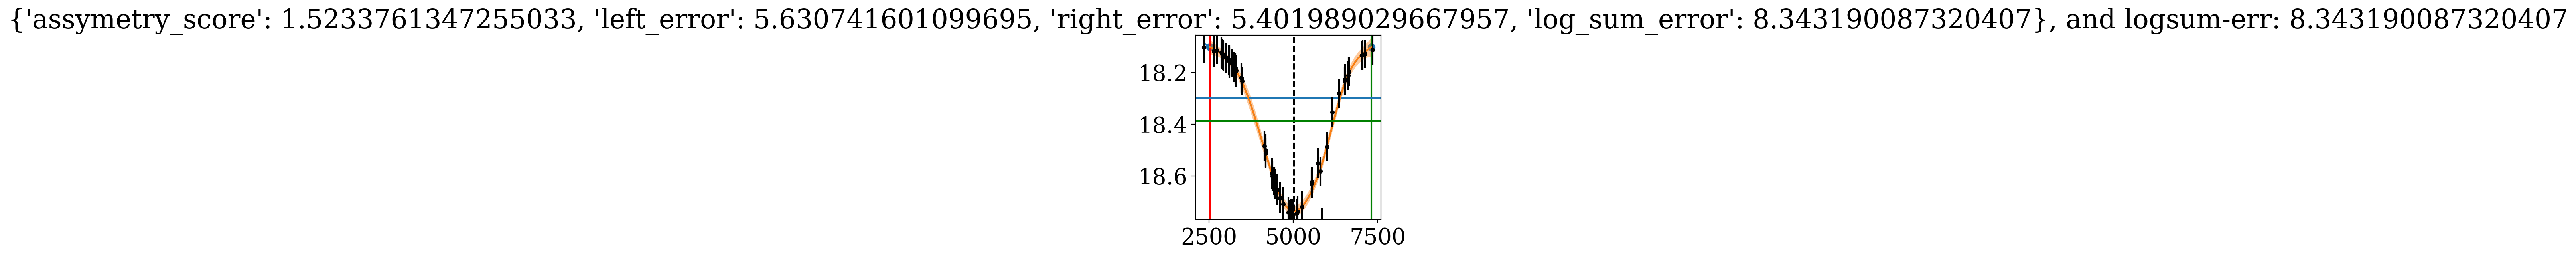

In [513]:
inf = summarize_dev_dips(x2, deviation(y2, yerr2), 
                        peak_close_rmv=25,loc_peak_thresh=6)


for k in inf[1].keys():
    _i = inf[1][f"{k}"]
    if _i['N_1sig_in_dip']>0:


        w_i, w_e = _i['window_end'], _i['window_start']
        
        print (f"working on {k}")
    
        
        x_select = np.where((x2>w_i-30) & (x2<w_e+30))
        xdat, ydat, yerrdat = x2[x_select], y2[x_select], yerr2[x_select]
        
        



        if len(xdat)>0:
            
            gpm = gp_my_dip(xdat, ydat, yerrdat)

            gp_inte = calc_gp_duration(gpm, xdat, ydat, yerrdat, astro_stats.biweight_location(y2))
            